In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim.models import word2vec  #pip install word2vec
from wordcloud import WordCloud  #pip install wordcloud
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.patches as mpatches
import matplotlib
path_to_csv = '../../../../cs82_advanced_machine_learning_data/HW2/papers.csv'

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 1. Plotting a word cloud to get an idea of the important words

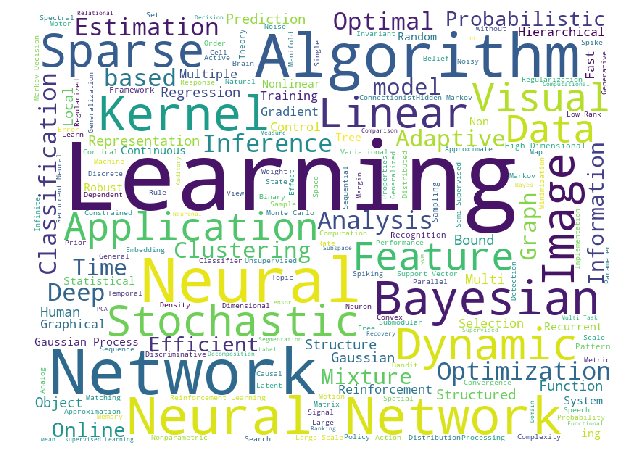

In [2]:
papers = pd.read_csv(path_to_csv)
features=['title']
papers=papers.loc[:,features]

#removing undesired words from the data 
undesired_words = ['Abstract Missing', 'Using', 'using', "New", "Based", 'Use', 'Method', 'Used', 
                   'Problem', 'Approach', 'Model', 'Models', 'via']
for word in undesired_words:
    papers['title'] = papers['title'].str.replace(word,'')


papers=papers.sample(frac=1,random_state=0)
train_qs = pd.Series(papers['title'].tolist()).astype(str)

qs_text = "".join(train_qs)

cloud =WordCloud(font_path=None, width=800, height=600, margin=2, ranks_only=None, 
                 prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, 
                 min_font_size=4, stopwords=None, random_state=None, background_color='white', 
                 max_font_size=None, font_step=1, mode='RGB', relative_scaling=.5, regexp=None, 
                 collocations=True, colormap=None, normalize_plurals=bool, contour_width=0, 
                 contour_color='black', repeat=None).generate(str(qs_text))
print(cloud)
plt.figure(figsize=(14,8))
plt.imshow(cloud);
plt.axis('off');
#Word Clouds on a image - https://github.com/amueller/word_cloud/blob/master/examples/alice_colored.png

# 2. Running t-SNE model and plot to try to find clusters of terms that would help determine topic names.

 We looked at the titles and abstract of each paper and convert them to word2vec matrices. We then reduced them to 2 dimensions using tsne and plotted the 2 tsne components to see if related words cluster together.



In [3]:
#For t-SNE model and plot, we have considered papers "title" and papers "abstract".
papers = pd.read_csv(path_to_csv)
features=['title','abstract']

#Removing undesired words that have been used frequently in the papers "abstract". 
for word in undesired_words:
    papers['abstract'] = papers['abstract'].str.replace(word,'')

papers=papers.loc[:,features]
papers.loc[:,'title'] = papers.title.apply(lambda x: x.lower())
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: x.lower())

#Remove chars that are not letters or numbers
regex = re.compile('\n')
papers.loc[:,'title'] = papers.title.apply(lambda x: regex.sub(' ',x))
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: regex.sub(' ',x))

#Remove stop words
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])

papers.loc[:,'title'] = papers['title'].apply(lambda x: x.split(' ')) 
papers.loc[:,'title'] = papers['title'].apply(lambda x: [word for word in x if word not in stops])

papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: x.split(' ')) 
papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: [word for word in x if word not in stops])

def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['title','abstract']:
        for sentence in data[col].iteritems():
            corpus.append(sentence[1])
            
    return corpus

corpus = build_corpus(papers)    

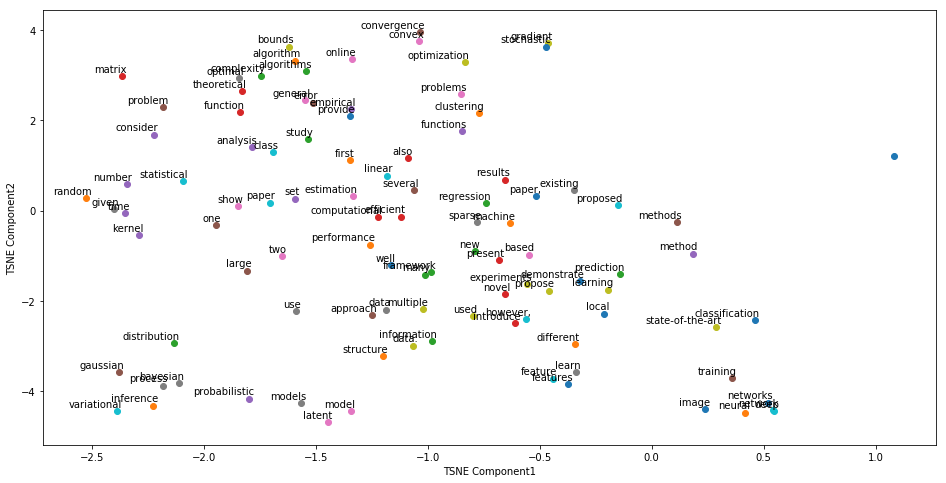

In [4]:
model = word2vec.Word2Vec(corpus, size=200, window=10, min_count=500, workers=4, seed=82)
model.corpus_count

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in sorted(model.wv.vocab):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', method='exact', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.xlabel('TSNE Component1')
    plt.ylabel('TSNE Component2')
    plt.show()
    
tsne_plot(model)

# 3. NMF for topic modeling and t-SNE for 2D-embedding

We have used 2D-embeddings to visualize the content of all NIPS papers until 2017. In doing so, we have used the method in [1] as a benchmark.

We have choosen the topics for clusters from our WordCloud analysis and the tsne clusters in section 1 and section 2 above for the words with higher appearance in NIPS papers till 2017. These topics are: 
### neural network, bayesian, clustering, optimization, learning, kernel, artificial, reinforcement, image.

[1]. https://www.kaggle.com/rjhere23/nips-papers-visualized-with-nmf-and-t-sne

In [5]:
#conn = sqlite3.connect('/Users/behrouz/Desktop/Harvard/Week 2/Class 2/section2/data/section2/database.sqlite')

#papers = pd.read_sql_query("select * from papers;", conn)
#papers.columns = ['id','year','title','event_type','pdf_name','abstract','paper_text']
papers = pd.read_csv(path_to_csv)

In [6]:
#For this analysis we will use "Papers Text" to identify the growth of the topics from 1997 until 2017. 

n_features = 1000
n_topics = 9
n_top_words = 10


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')


tfidf = tfidf_vectorizer.fit_transform(papers['paper_text'])


nmf = NMF(n_components=n_topics, random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [7]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [8]:
topics = ['neural network',
          'bayesian',
          'clustering',
          'optimization',
          'learning',
          'kernel',
          'artificial',
          'reinforcement',
          'image']  

In [9]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [10]:
###code used to create the plot for getting the colors 
#plt.style.use('ggplot')
colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
                   [ 0.22685121,  0.51898501,  0.66574396,  1. ],
                   [ 0.38731259,  0.57588621,  0.39148022,  1. ],
                   [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
                   [ 1.        ,  0.78937332,  0.11607843,  1. ],
                   [ 0.75226453,  0.52958094,  0.16938101,  1. ],
                   [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
                   [ 0.60000002,  0.60000002,  0.60000002,  1. ],
                   [ 0.51898501,  0.22685121,  0.92752019,  1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

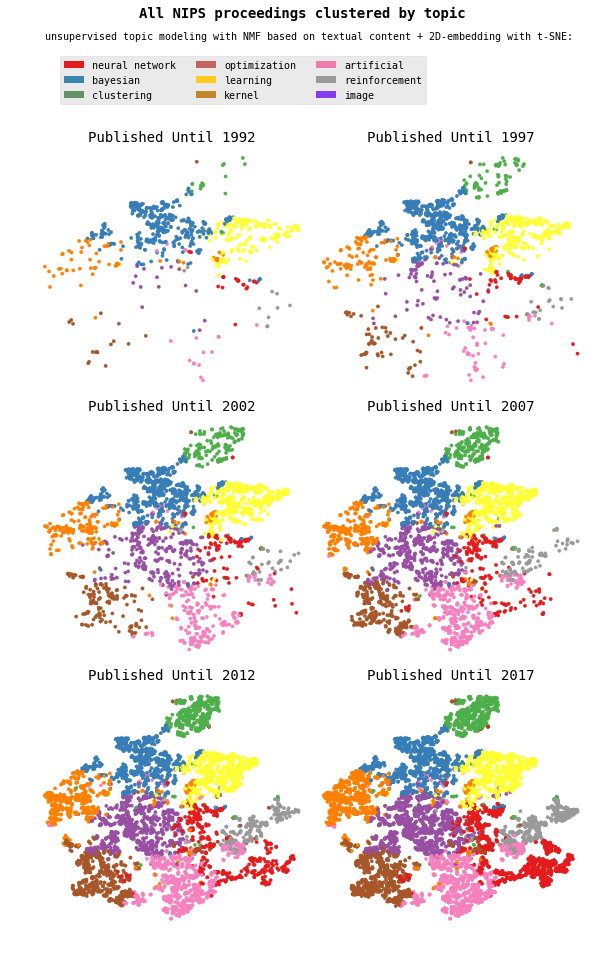

In [11]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1992,1997,2002,2007,2012,2017], range(6)):
    data = tsne_embedding[papers['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=10,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Published Until {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("All NIPS proceedings clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')
#fig.legend(legend_list)
fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

# 4. Find top topics using LDA and plot them against time

Since topic modeling is somewhat subjective, we also used LDA to try to model topics and see if we can find trends.
To do this, we first found 9 topics and tried to give them a name based on the papers and words that are assigned to them with highest probabilities. Then we took all the papers from each year and took the mean of their probabilities for each topic. We plotted the topics against time (in years) to see if there is any visible trend.

In [12]:
df_papers = pd.read_csv(path_to_csv)
df_papers.head()
df_papers_orig = df_papers.copy()

# LOWER CASE
df_papers.loc[:,'title'] = df_papers.title.apply(lambda x : x.lower())
df_papers.loc[:,'paper_text'] = df_papers.paper_text.apply(lambda x : x.lower())

#KEEP ONLY ALPHANUMERIC
regex = re.compile(r'\W+')
df_papers.loc[:,'title'] = df_papers.title.apply(lambda x: regex.sub(' ', x))
df_papers.loc[:,'paper_text'] = df_papers.paper_text.apply(lambda x: regex.sub(' ', x))

#CONVERT TO BOW
df_papers.loc[:,'title'] = df_papers['title'].apply(lambda x: x.split(' '))
df_papers.loc[:,'paper_text'] = df_papers['paper_text'].apply(lambda x: x.split(' '))

porter = PorterStemmer()
stops = set(stopwords.words("english"))
stops = stops.union(set("year"))

#REMOVE STOP WORDS
df_papers.loc[:,'title'] = df_papers['title'].apply(lambda x: [word for word in x if word not in stops])
df_papers.loc[:,'paper_text'] = df_papers['paper_text'].apply(lambda x: [word for word in x if word not in stops])

# INCREASE WEIGHT ON THE WORDS USED IN THE TITLES BY COUNTING THEM 4 times
title_overcount_factor = 3

def build_corpus(data): 
    corpus = []
    for index, row in data.iterrows():
        title = []
        for i in range(title_overcount_factor):
            title = row['title'] + title
        content = title + row['paper_text']
        corpus.append(" ".join(content))
    return corpus

corpus = build_corpus(df_papers)


In [13]:
n_samples = len(corpus)
print ("There are %i documents to analyze." % n_samples)
n_features = 2000
n_components = 10
n_top_words = 20

There are 7241 documents to analyze.


In [14]:
from datetime import datetime
from time import time

n_features = 2000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time() - t0))
print()

print("\nThe shape of our count vector matrix: ",tf.shape)
#print(tf_vectorizer.get_feature_names()[:30])


done in 18.847s.


The shape of our count vector matrix:  (7241, 2000)


In [15]:
n_components = 9
n_top_words = 20

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

Fitting LDA models with tf features, n_samples=7241 and n_features=2000...
done in 113.958s.


In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    print()
    
    
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: learning kernel data loss xi classification function problem training regression class algorithm methods error method linear yi label convex based

Topic #1: learning state policy action time algorithm value function reward regret optimal agent problem states actions reinforcement control decision based model

Topic #2: model time neurons neural figure neuron input spike system activity response information stimulus fig network signal cells cell noise brain

Topic #3: algorithm algorithms graph problem gradient optimization time tree learning node xt function convex nodes number convergence stochastic online problems step

Topic #4: matrix data clustering sparse algorithm rank problem points matrices method analysis dimensional cluster low number methods spectral linear clusters figure

Topic #5: theorem log function bound distribution probability let case bounds random functions sample given information error theory proof following lemma consider

Topic

In [17]:
doc_topic_distrib = lda.transform(tf)
print(doc_topic_distrib.shape)

top_n_titles = 5
for i in range(n_components):
    idx=doc_topic_distrib[:,i].argsort()[::-1][:top_n_titles]
    doc_topic_distrib[idx]
    print("Topic %d" %i )
    print(df_papers_orig.loc[idx,'title'].values)
    print()

(7241, 9)
Topic 0
['A General and Efficient Multiple Kernel Learning Algorithm'
 'Similarity-based Learning via Data Driven Embeddings'
 'Learning with Average Top-k Loss'
 'Efficient Convex Relaxation for Transductive Support Vector Machine'
 'Learning Kernels with Radiuses of Minimum Enclosing Balls']

Topic 1
['Learning to Take Concurrent Actions'
 'The Effect of Eligibility Traces on Finding Optimal Memoryless Policies in Partially Observable Markov Decision Processes'
 'Improved Switching among Temporally Abstract Actions'
 'Cyclic Equilibria in Markov Games'
 'Playing is believing: The role of beliefs in multi-agent learning']

Topic 2
['An Analog VLSI Model of Periodicity Extraction'
 'Neuronal Maps for Sensory-Motor Control in the Barn Owl'
 'Stimulus Encoding by Multidimensional Receptive Fields in Single Cells and Cell Populations in V1 of Awake Monkey'
 'Computer Simulation of Oscillatory Behavior in Cerebral Cortical Networks'
 'A model of transparent motion and non-transpa

In [18]:
topic_names = {0:'Kernel',
               1:'Reinforcement',
               2:'Medical',
               3:'Linear Model',
               4:'Clustering',
               5:'Probabilistic Models',
               6:'Neural Network',
               7:'Bayesian',
               8:'Image Recognition',
              }


In [19]:
topic_list = [value for key, value in topic_names.items()]
df_topics = pd.DataFrame(doc_topic_distrib, columns=topic_list)
print(df_topics.shape)
df_topics.head()
df_topics['year'] = df_papers['year']


(7241, 9)


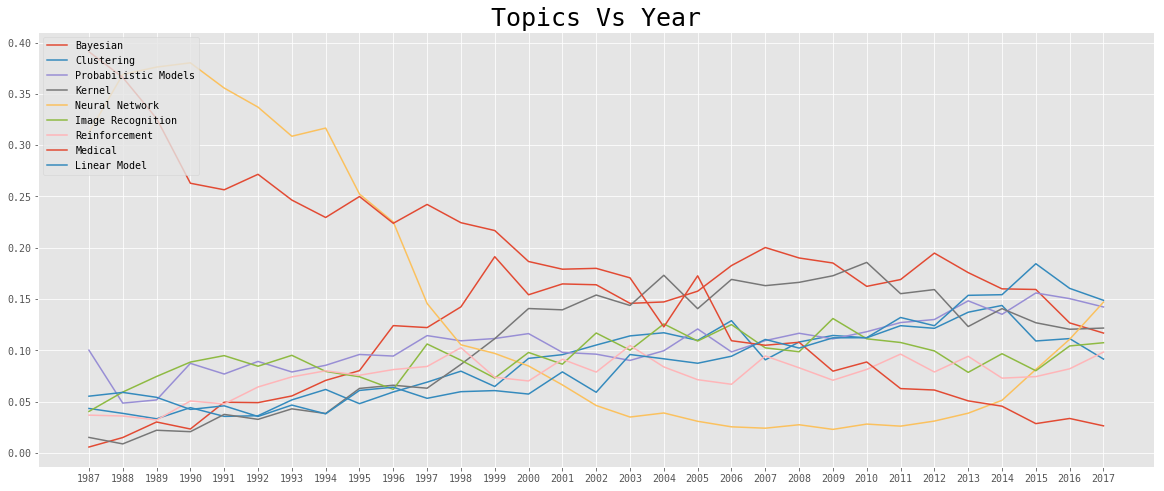

In [20]:
df_topics_year = df_topics.groupby('year').mean()
topics = set(topic_list)

def plot_trend(df, topics, title):
    plt.figure(figsize=(20,8))
    plt.title(title, fontsize=25)
    for topic in topics:
        plt.plot(df.index, df.loc[:,topic])
    plt.xticks(df.index)
    plt.legend(loc = 'upper left')


plot_trend(df_topics_year, topics, "Topics Vs Year")


# 5. Use TFIDF to find the important terms for each year and filter out UPWARD and DOWNWARD trending terms.

After looking at the trends based on topics, we realised that it was fairly difficult to assign topics to the clusters of words and the process is highly subjective.  

We decided to pursue a different path and use raw tfidf scores on two word terms. Two word terms seemed to represent larger ideas and concepts fairly well. And because we have a fairly large number of papers and text for each year, we were able to plot the upward trending concepts and downward trending concepts using the tfidf scores for the relevant two word terms. 

After the initial plot, we recognized several terms that are not relevant to machine learning and we created a list to filter those out. 


In [21]:
# PARAMETERS FOR TFIDF
min_ngram = 2
max_ngram = 2

max_df = 0.90
min_df = 2
max_features = 500

vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram), max_features = max_features, max_df = max_df)
X = vectorizer.fit_transform(corpus)
print(X.get_shape())

# CONVERT TFIDF RESULTS TO PANDAS DATA FRAME
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

# ADD THE YEAR COLUMN TO THE DATAFRAME
df_tfidf['year'] = df_papers['year']
df_tfidf['count'] = 1

#GET THE NUMBER OF PAPERS FOR EACH YEAR 
counts = df_tfidf.groupby(['year']).agg(['count'])['count']

#TAKE THE MEAN IDF SCORE FOR EACH FEATURE
df_tfidf_year = df_tfidf.groupby(['year']).mean()

#ADD THE COUNT COLUMN FOR EACH YEAR FOR FUTURE USE
df_tfidf_year['count'] = counts



(7241, 500)


UPWARD:
{'deep learning', 'supervised learning', 'computer vision', 'generative models', 'pattern recognition', 'neural networks', 'reinforcement learning', 'stochastic optimization'}
DOWNWARD:
{'bayesian inference', 'topic models', 'dirichlet process', 'principal components', 'linear model', 'component analysis', 'neural computation', 'belief propagation'}


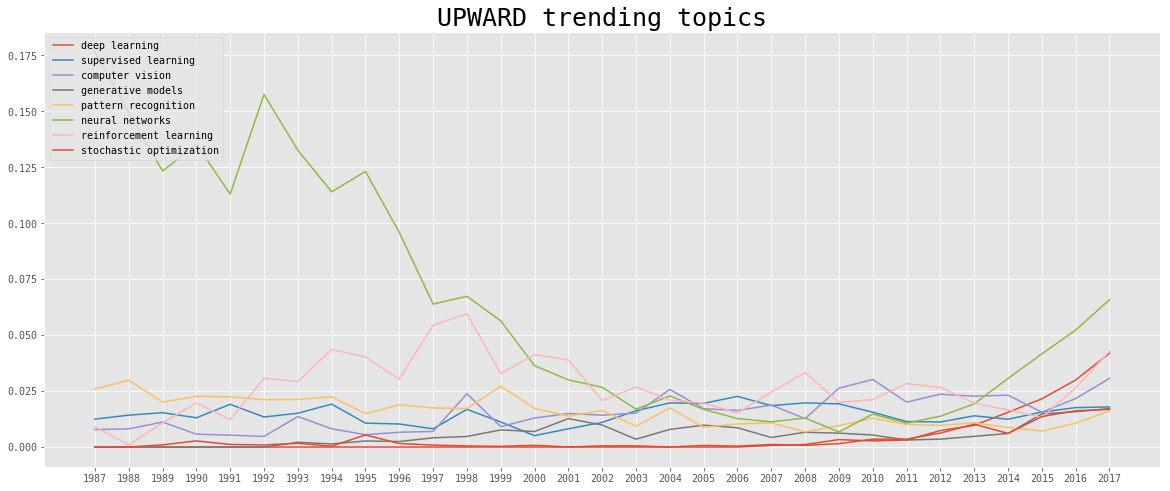

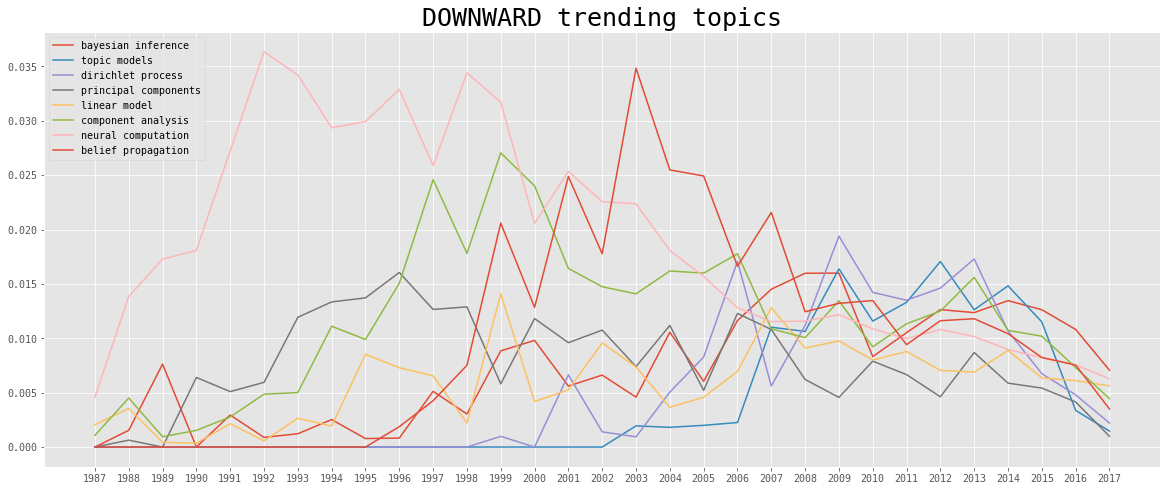

In [22]:
# PLOT ONLY TERMS THAT HAVE A CONSISTENTLY RISING TREND
plt.rcParams['figure.figsize'] = [10, 5]
def upward_trend (column):
        upward_trend = df_tfidf_year.loc[2017,column] > df_tfidf_year.loc[2016, column] > df_tfidf_year.loc[2015, column] 
        return upward_trend

def downward_trend(column):
        downward_trend = df_tfidf_year.loc[2017,column] < df_tfidf_year.loc[2016, column] < df_tfidf_year.loc[2015, column]< \
        df_tfidf_year.loc[2014, column] 
        return downward_trend


topics_upward = set()
topics_downward = set()
for column in df_tfidf_year.columns:
    if upward_trend(column) :
            topics_upward.add(column)
    elif downward_trend(column):
            topics_downward.add(column)
       

    
# REMOVE TOPICS THAT ARE KNOWN TO BE NOT RELATED TO MACHINE LEARNING
remove_set = set(["systems pages", "neural network", "related work", "conference neural", "mini batch" 
                   "log log", "low rank", "end end", "international conference", "arxiv preprint", 
                  "related work", "preprint arxiv", "two different", "long term" , "fixed point", "error rates", "standard deviation",
                  'et al', 'kernel methods',  'supported part', 'multi task', 'total number', 
                  'two dimensional', 'cifar 10', 'natural language', 'error rates', 'task learning', 'artificial neural', 'editors advances', 
                  'standard deviation', 'count', 'pattern analysis', 'optimal policy', 'reward function', 
                  'deep neural', 'number iterations', 'analysis machine', 'kernel function', 'recurrent neural', 'state action', 'gaussian kernel', 
                  'joint distribution', 'function approximation', 'input space', 'international conference', 'number parameters', 'proceedings ieee', 
                  'proposed method', 'real data', 'information processing', 'domain adaptation', 
                  'conference computer', 'learning methods', 'model based', 'x0 x0', 'processing systems', 'end end', 'advances neural', 
                  'neural network', 'density estimation', 'al 2016', 'conference neural', 'theoretical analysis', 'see figure', 
                  'ground truth', 'linear combination', 'state art', 'synthetic data', 'theoretical results', 'cost function', 'see fig', 'recent work', 
                  'arxiv preprint', 'high probability', 'results shown', 'experimental results', 'systems pages', 'labeled data', 
                  'training data', 'two different', 'mini batch', 'preprint arxiv', 'would like', 'neural information', 'conference learning', 
                  'mean squared', 'prior knowledge', 'machine intelligence','system nips', '40 50', 'fixed point', 'non gaussian', 'long term', 'non parametric', 'information theoretic', 'related work'
                  'neural computation', 'ij ij', 'gaussian noise', '20 30', 'principal component', '15 20', 'given set', 'xi xj', '13 14', 'mixture model', 'vector machine', 'small number', 'message passing', 
                  'high dimensional', 'covariance matrix', 'nips pages', 'described section', 'firing rate', 'mit press', 'previous work', 'diagonal matrix', '16 17', 
                  'em algorithm', 'learning rule', 'markov random', 'data points', 'technical report', '100 150', '20 40', 'least squares', 'many applications', 'fig shows', 'graphical model', 
                  'learning problems', 'edu abstract', 'gaussian mixture', '40 60', 'number clusters', '20 10', 'one dimensional', 'random fields',
                  'feature selection', 'state space', 'sample size', 'non zero', 'graphical models', 'science university', 'partition function', 'xt xt', 
                  'main result', 'special case', 'systems nips', 'vision pattern', 'signal processing', 'network architecture','dynamic programming', 'kernel matrix', 
                  'markov decision', 'kernel learning', 'maximum likelihood', 'computational cost', 'computational complexity', 'likelihood function'
                 
                 ])
        
# FINAL LIST OF TOPICS TO PLOT
topics_upward = topics_upward.difference(remove_set)
topics_downward = topics_downward.difference(remove_set)

#topics = set(["computer vision", "deep learning", "neural networks", "value function", "pattern recognition",
#               "reinforcement learning" ,"information processing"])




plot_trend(df_tfidf_year, topics_upward, "UPWARD trending topics")
plot_trend(df_tfidf_year, topics_downward,  "DOWNWARD trending topics")

print("UPWARD:")
print(topics_upward)
print("DOWNWARD:")
print(topics_downward)

# DELETE CELLS BELOW

Int64Index([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
            1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='year')
52


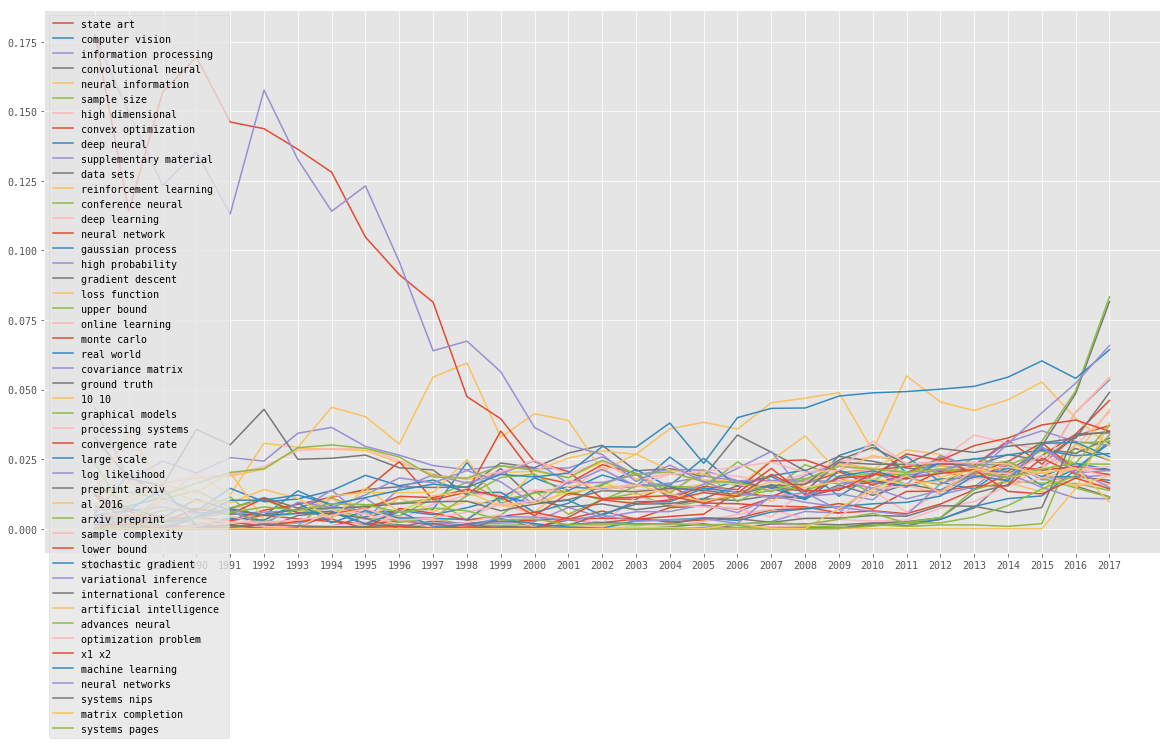

In [23]:
# PARAMETERS FOR PLOTTING
topN_topics = 25  # PLOT THE TOPICS THAT FEATURED IN THE TOPN OF EACH YEAR
min_year = 2013   # THE MIN BOUND FOR THE YEARS TO LOOK AT TO FIND THE TOP TOPICS
max_year = 2017   # THE MAX BOUND FOR THE YEARS TO LOOK AT TO FIND THE TOP TOPICS


# ITERATE THROUGH EACH YEAR AND PICK THE TOP (top_n) TOPICS FROM EACH YEAR TO PLOT
years = df_tfidf_year.index
print(years)
topics  = set()
for year in years:
        if (year >= min_year) & (year <=max_year):
            tfidf_sorted = df_tfidf_year.T.sort_values(by=[year], ascending=False)
            topics = topics.union(set(tfidf_sorted.index[:topN_topics]))

print(len(topics))

# REMOVE TOPICS THAT ARE KNOWN TO BE NOT RELATED TO MACHINE LEARNING
remove_set = set(["using", "et al", "count", "based", "via", "semi", "online", 
                  "large", "multi", "analysis", "data", "stochastic", "log log", "low rank"])

# FINAL LIST OF TOPICS TO PLOT
topics = topics.difference(remove_set)

plt.figure(figsize=(20,10))
for topic in topics:
    plt.plot(df_tfidf_year.index, df_tfidf_year.loc[:,topic])
plt.xticks(df_tfidf_year.index)
plt.legend(loc = 'upper left')
